# Bond Sensitivities

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
import scipy.optimize


In [119]:
# Set seaborn style and context
sns.set_theme(
    style="whitegrid",  # Background style ("whitegrid", "darkgrid", "white", "dark", "ticks")
    context="notebook",  # Context for scaling elements ("paper", "notebook", "talk", "poster")
    palette="deep",     # Color palette ("deep", "muted", "bright", "pastel", "dark", "colorblind")
    font="sans-serif",  # Font family
    font_scale=1.1,     # Font scaling relative to context
    rc={
        'figure.figsize': (8, 6),  # Default figure size
        'figure.facecolor': 'white',  # Figure background color
        'axes.grid': True,  # Show grid by default
        'grid.alpha': 0.3,  # Grid transparency
        'axes.edgecolor': '.15',  # Edge color
        'axes.labelpad': 8,  # Padding for axis labels
        'axes.titlepad': 12,  # Padding for title
        'lines.linewidth': 1.75,  # Line width
        'patch.edgecolor': 'black',  # Edge color for patches
        'patch.force_edgecolor': True,  # Always show edges on patches
        'xtick.bottom': True,  # Draw ticks on bottom
        'ytick.left': True,  # Draw ticks on left
    }
)

## Building the Yield Curve

Since Bond Prices are a little more involved to find than stock prices, we can use this opportunity to practice building a term-structure from interest rates.

In [93]:
# building interest rates
# T is yearly
# Read tables from a webpage
tables = pd.read_html('https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025')

In [94]:
yesterday_info = tables[0].iloc[-1]

In [95]:
maturities = [1/12, 1.5/12, 2/12, 3/12, 4/12, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
yields = yesterday_info.to_list()[12:]

In [96]:
# Cubic spline is a popular method for Term Structure of Interest Rate Curve to Existing yields
from scipy.interpolate import CubicSpline
cs = CubicSpline(maturities, yields, bc_type='natural')

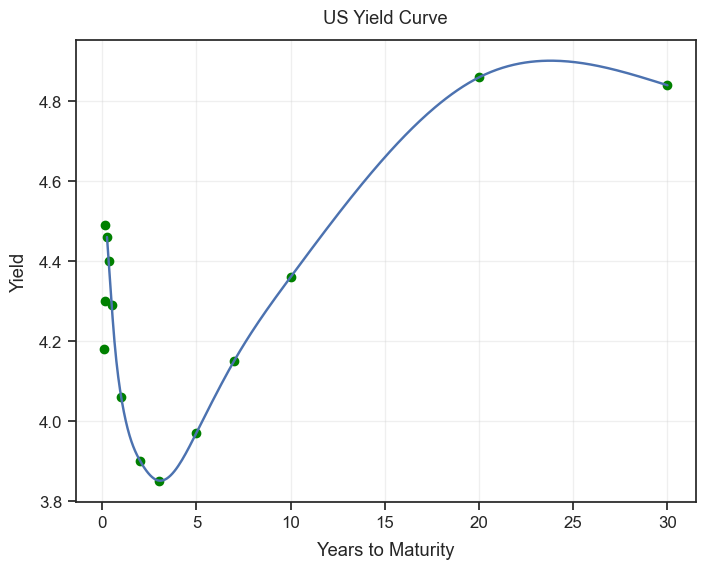

In [121]:
x_new = np.linspace(0.25, 30, 300)
y_new = cs(x_new)
plt.scatter(maturities,yields, color='green')
plt.plot(x_new, y_new)
plt.xlabel("Years to Maturity")
plt.ylabel("Yield")
plt.title("US Yield Curve")
plt.show()

## Building Bonds

In [376]:
class Bond:
    def __init__(self, term_structure, coupon_rate=0.05, coupon_period=0.5, ttm=10, face_value=100):
        self.coupon_rate = coupon_rate
        self.coupon_period = coupon_period
        self.ttm = ttm
        self.face_value = face_value
        #build our cash flow df
        self.df = self.get_df()
        # get the rates required to price the bond
        self.rates = term_structure(self.df['date'])/100
        # get our bond price
        self.price = self.get_price(self.rates)
        self.YTM = self.get_ytm()
        # metrics
        self.dy = self.get_dy(self.YTM)
        self.DV01 = self.get_DV01()
        self.D_mac = self.get_Dmac()
        self.D = self.get_D()
        self.dyy = self.get_dyy(self.YTM)
        self.C = self.get_C()
        self.dr = self.get_dr(self.rates)

    def get_df(self):
        # build bond cashflows
        cash_flows = [self.coupon_rate*self.coupon_period*self.face_value for _ in range(int(self.ttm/self.coupon_period))]
        cash_flows[-1] += self.face_value
        dates = np.arange(self.coupon_period,self.ttm+self.coupon_period,self.coupon_period)
        bond_df = pd.DataFrame({'date':dates, 'cash_flow':cash_flows})
        return bond_df

    def get_price(self, rates):
        discount_factors = (1 + rates*self.coupon_period)**(-1 * self.df['date']/self.coupon_period)
        price = sum(discount_factors * self.df['cash_flow'])
        return price

    def get_ytm(self):
        bond_price_diff = lambda y, prc: prc - self.get_price(y)
        YTM = scipy.optimize.newton(lambda y: bond_price_diff(y, self.price), 0.01, tol=0.00001, maxiter=10_000)
        return YTM

    def get_dy(self, y):
        deriv_df = self.df.copy()
        deriv_df['frac'] = deriv_df['cash_flow'] * (deriv_df['date']/self.coupon_period) / (1 + y*self.coupon_period)**(deriv_df['date']/self.coupon_period + 1)
        deriv = -1*sum(deriv_df['frac'])
        return deriv

    def get_dr(self, rates):
        deriv_df = self.df.copy()
        deriv_df['frac'] = deriv_df['cash_flow'] * (deriv_df['date']/self.coupon_period) / (1 + rates*self.coupon_period)**(deriv_df['date']/self.coupon_period + 1)
        deriv = -1*sum(deriv_df['frac'])
        return deriv
        
    def get_DV01(self):
        return -1 * 1/10_000 * self.dy

    def get_Dmac(self):
        return -1 * self.dy * 1/self.price * (1 + self.YTM*self.coupon_period)

    def get_D(self):
        return self.D_mac/(1 + self.YTM*self.coupon_period)

    def get_dyy(self, y):
        double_deriv_df = self.df.copy()
        double_deriv_df['frac'] = double_deriv_df['cash_flow'] * (double_deriv_df['date']/self.coupon_period) * (double_deriv_df['date']/self.coupon_period + 1) / (1 + y*self.coupon_period)**(double_deriv_df['date']/self.coupon_period + 2)
        double_deriv = sum(double_deriv_df['frac'])
        return double_deriv

    def get_C(self):
        return self.dyy / self.price


In [378]:
x = Bond(cs, coupon_rate=0)

## Sensitivity with repsect to YTM

In [381]:
# we can use a single scaler if all rates are the same
print(f'Yield to Maturity (YTM) of bond: {x.YTM}')

Yield to Maturity (YTM) of bond: 0.043599999988618465


In [383]:
# sanity check
print(f'Price of bond given term structure: {round(x.price,3)}')
print(f'Price of bond given YTM: {round(x.get_price(x.YTM),3)}')

Price of bond given term structure: 64.965
Price of bond given YTM: 64.965


We can simplify movements in the term structure by modeling movements in the bonds YTM. First, we observe the price of a bond as a fuction of its YTM:

$$ B(y,T) = \sum_{i=1}^n \frac{C_{T_i}}{(1 + y)^{T_i}} + \frac{100}{(1 + y)^{T_n}},$$

The sensitivy with repect to the yield follows as

$$ \frac{\partial B(y,T)}{\partial y} = -1 * \sum_{i=1}^n \frac{C_{T_i} * T_i}{(1 + y)^{T_i + 1}} + \frac{100 * T_n}{(1 + y)^{T_n + 1}}.$$

It is important to note that the $y$ defined here is for that period, i.e. annualized YTM per period.

In [386]:
print(f'Derivative of bond price w.r.t yield: {x.dy}.')

Derivative of bond price w.r.t yield: -1271.5871498051024.


As we can see, the sensitivty of the bond price to a shifts in the yield is $-1,000$! That is quite large, but it is important to note that the interest rate moves in terms of basis points (bps) where a single bp is $0.01\%$ or $0.0001$, so the sensitivity is normally quoted in terms of bps:

$$\frac{1}{10,000}\frac{\partial B(y,T)}{\partial y}$$

In [389]:
deriv_bp = x.dy * (1/10_000)
print(f'Derivative of bond price w.r.t yield: {deriv_bp}.')

Derivative of bond price w.r.t yield: -0.12715871498051023.


This is a more intuitive and helpful value, if the yield of the bond increases by one basis point, then we should expect the price of our bond to decrease by about $10$ cents.

## Duration

Now that we have our bonds sensitivty to changes in the yield, we can observe the bonds **Duration**. The different duration measures of a bond are very closely related to the sensitivity of the bond to shifts in yield, but they differ due to "not letting enough math people be involved with bonds from the get to" as one of my old professors explained.

### Dollar Duration (DV01)

$$ -1 * \frac{1}{10,000}\frac{\partial B(y,T)}{\partial r}$$

In [393]:
print(f'DV01 of bond: {x.DV01}')

DV01 of bond: 0.12715871498051023


Yes, the dollar duration is just the negative of the sensitivty to a bp change. This does nothing other than allow us to think of duration as "amount to lose" instead of "amount to change".

### Macauly Duration

The Macauly Duration is a time weighted average of payments that measures how far in the future a bond is paid off.

$$D_{\text{MAC}} = -1 * \frac{\partial B(y,T)}{\partial y} * \frac{1}{B(y,T)} * (1 + y)$$

In [397]:
print(f'Macauly Duration of bond: {round(x.D_mac, 3)}')

Macauly Duration of bond: 20.0


### Duration (Modified Duration)

The duration is used to approximate the (*minus*) percentage movement in bond price for a 100 bp ($1\%$) change in the bonds yield.

$$ D = -1 * \frac{\partial B(y,T)}{\partial y} * \frac{1}{B(y,T)} = \frac{D_{\text{MAC}}}{1+y}.$$

It is important to note that the "100 bp change" is not observed in the formula, but can be extracted by observing

$$ 
\begin{aligned}
D &= -1 * \left [ \frac{\partial B(y,T)}{\partial y} * \underbrace{0.01}_\text{Sensitivity to 100 bp change} \right ] * \left [ \frac{1}{B(y,T)} * \underbrace{100}_\text{percentage movement} \right ] \\
\\
 &= -1 * \frac{\partial B(y,T)}{\partial y} * \frac{1}{B(y,T)}
\end{aligned}
$$


In [400]:
print(f'Duration of bond: {round(x.D, 3)}')

Duration of bond: 19.573


### Convexity ($C$)

Moving back to direct sensitivities, bond convexity to yield changes in another important metric to observe. The convexity is the rate of change of the sensitivity to changes in the yield.

$$ C = \frac{\partial^2 B(y,T)}{\partial y^2} * \frac{1}{B(y,T)}$$

where

$$ \frac{\partial^2 B(y,T)}{\partial y^2} = \sum_{i=1}^n \frac{C_{T_i} * T_i * (T_i + 1)}{(1 + y)^{T_i + 2}} + \frac{100 * T_n * (T_i + 1)}{(1 + y)^{T_n + 2}}.$$

In [403]:
print(f'Convexity of bond: {x.C}')

Convexity of bond: 402.26985945137517


## Observing Shifts

In [431]:
shifts = np.arange(0, 0.15, 1/1_000)
new_price = np.array([x.get_price(shift) for shift in shifts])

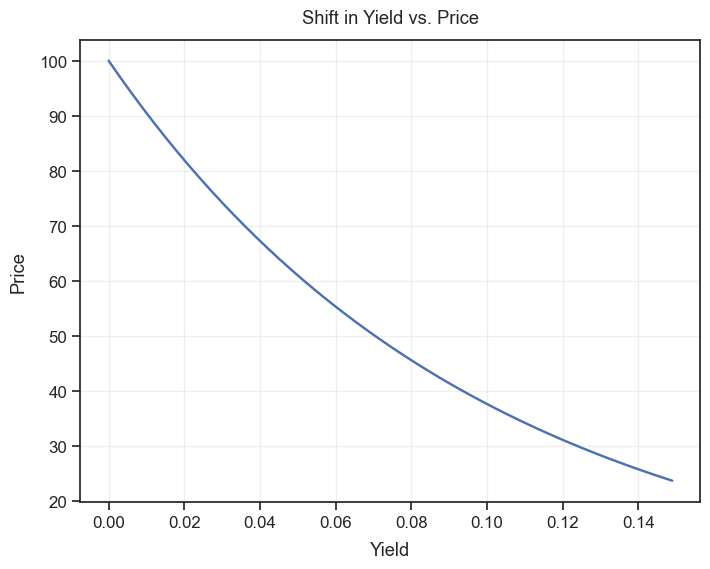

In [433]:
plt.plot(shifts, new_price)
plt.xlabel("Yield")
plt.ylabel("Price")
plt.title("Shift in Yield vs. Price")
plt.show()

In [435]:
new_sensitivity = 1/10_000 * np.array([x.get_dy(shift) for shift in shifts])

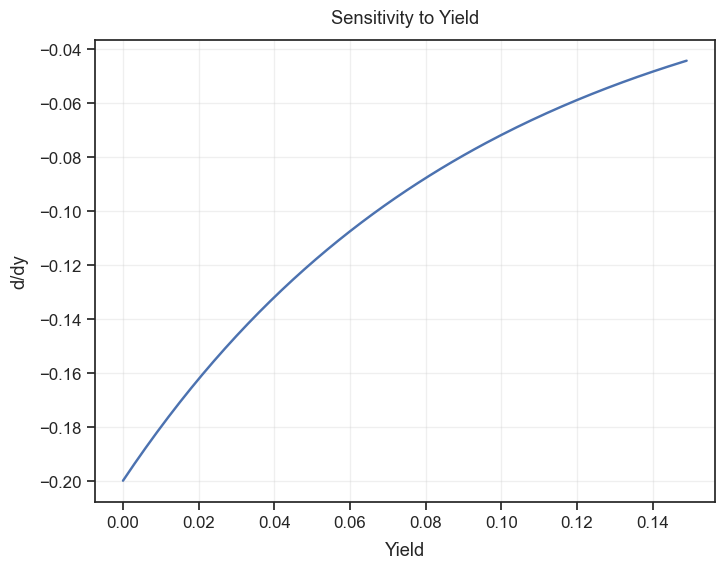

In [437]:
plt.plot(shifts, new_sensitivity)
plt.xlabel("Yield")
plt.ylabel("d/dy")
plt.title("Sensitivity to Yield")
plt.show()

In [439]:
new_c = 1/10_000 * np.array([x.get_dyy(shift) for shift in shifts])

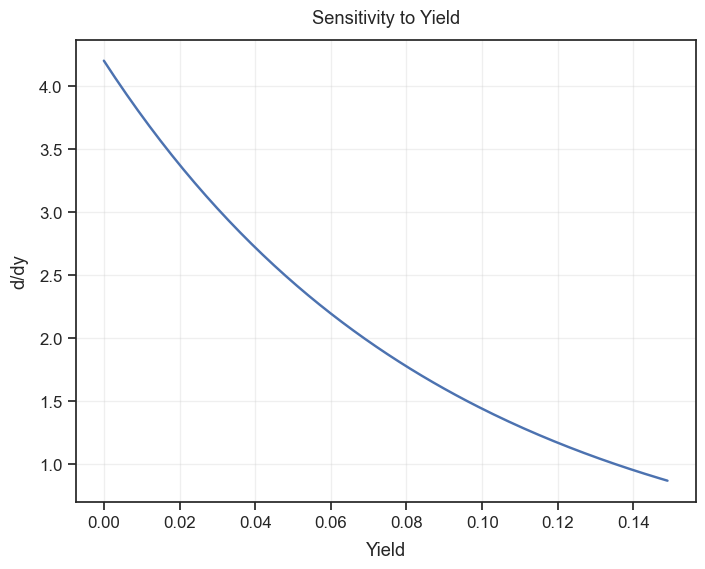

In [441]:
plt.plot(shifts, new_c)
plt.xlabel("Yield")
plt.ylabel("d/dy")
plt.title("Sensitivity to Yield")
plt.show()

## Sensitivity to Spot Rate

We can also define the bond price as a function of a shift in the term structure ($r$):
$$ B(r,T) = \sum_{i=1}^n \frac{C_{T_i}}{(1 + r_1(T_i) + r)^{T_i}} + \frac{100}{(1 + r_1(T_n) + r)^{T_n}},$$
where $r_1(\cdot)$ is the one period rate for time $T_i$. These cash flows can be seen in the bonds dataframe where $r=0$.

In [444]:
x.df.tail()

,date,cash_flow
15,8.0,0.0
16,8.5,0.0
17,9.0,0.0
18,9.5,0.0
19,10.0,100.0


We can now differential with respect to the change in spot rate to get the bonds sensitivity:

$$ \frac{\partial B(r,T)}{\partial r} = -1 * \sum_{i=1}^n \frac{C_{T_i} * T_i}{(1 + r_1(T_i))^{T_i + 1}} + \frac{100 * T_n}{(1 + r_1(T_n))^{T_n + 1}}.$$

In [447]:
x.dr

-1271.5871496563818

### Spot Dollar Duration (DV01)

$$ -1 * \frac{1}{10,000}\frac{\partial B(r,T)}{\partial r}$$

In [450]:
spot_DV01 = -1 * 1/10_000 * x.dr
print(f'Spot DV01 of bond: {spot_DV01}')

Spot DV01 of bond: 0.1271587149656382


# Barbell Hedge

In [453]:
# Build term structure to match question
from scipy.interpolate import CubicSpline
cs = CubicSpline([x for x in range(11)], [5 for _ in range(11)], bc_type='natural')

In [455]:
P_1 = Bond(cs, coupon_rate=0, coupon_period=1, ttm=1, face_value=1)
P_5 = Bond(cs, coupon_rate=0, coupon_period=1, ttm=5, face_value=1)
P_10 = Bond(cs, coupon_rate=0, coupon_period=1, ttm=10, face_value=1)

What combination of 1 and 10 year bonds would you need to exactly match the value and duration of $1 of face value of the five year bond?

Since our interest rate curve is flat, we can use this derivation of portfolio dollar duration:
$$P_pD_p = N^1*P_1*D_1 + N^{10}*P_{10}*D_{10}$$

So, all we need to do is ensure the following two equalities hold:
$$\begin{aligned}
P_5 &= N^1*P_1 + N^{10}*P_{10}\\
D_5P_5 &= N^1*P_1*D_1 + N^{10}*P_{10}*D_{10}
\end{aligned}$$
$$\downarrow$$
$$
\begin{align}
N^1 = \frac{P_5(D_5-D_{10})}{P_1(D_1-D_{10})} && N^{10} = \frac{P_5(D_1 - D_5)}{P_{10}(D_1 - D_{10})}
\end{align}$$

In [458]:
N1 = (P_5.price*(P_5.D-P_10.D))/(P_1.price*(P_1.D - P_10.D))
N10 = (P_5.price*(P_1.D-P_5.D))/(P_10.price*(P_1.D - P_10.D))
print(f'Number of 1 year bonds: {N1}')
print(f'Number of 10 year bonds: {N10}')

Number of 1 year bonds: 0.45705690963850815
Number of 10 year bonds: 0.5672362822698394


In [551]:
class Portfolio:
    def __init__(self, bonds, quantities):
        self.bonds = bonds
        self.N = quantities
        self.price = self.get_price()
        self.D = self.get_D()
        self.C = self.get_C()

    def get_price(self, rate=None):
        if rate is not None:
            p = sum([x.get_price(rate)*n[0] for x, n in zip(self.bonds, self.N)])
        else:
            p = sum([x.get_price(x.rates)*n[0] for x, n in zip(self.bonds, self.N)])
        return p

    def get_D(self, rate=None):
        if rate is not None:
            s = sum([x.D*x.get_price(rate)*n[0] for x, n in zip(self.bonds, self.N)])
        else:
            s = sum([x.D*x.get_price(x.rates)*n[0] for x, n in zip(self.bonds, self.N)])
        return s/self.price
   
    def get_C(self, shift=0):
        c = sum([x.C*x.get_price(x.rates + shift)*n[0] for x, n in zip(self.bonds, self.N)])
        return c/self.price

In [553]:
Rep_p = Portfolio([P_1, P_10], np.array([[N1], [N10]]))

In [555]:
print(f'Price of P_5: {P_5.price}')
print(f'Duration of P_5: {P_5.D}')

Price of P_5: 0.7835261664684589
Duration of P_5: 4.761904984292005


In [557]:
print(f'Price of replicating portfolio: {Rep_p.price}')
print(f'Duration of replicating portfolio: {Rep_p.D}')

Price of replicating portfolio: 0.7835261664684587
Duration of replicating portfolio: 4.761904984292004


What’s the convexity of 5 year and the hedging portfolio. If you go long the 5 year and short the hedging portfolio what do you think will happen if rates make a big shift (in parallel)?

In [560]:
print(f'Convexity of P_5: {P_5.C}')

Convexity of P_5: 27.21088583632312


In [562]:
print(f'Convexity of replicating Portfolio: {Rep_p.C}')

Convexity of replicating Portfolio: 45.351476464431066


In [564]:
P_5_change = np.array([P_5.get_price(shift) for shift in shifts])
portfolio_change = np.array([Rep_p.get_price(shift) for shift in shifts])

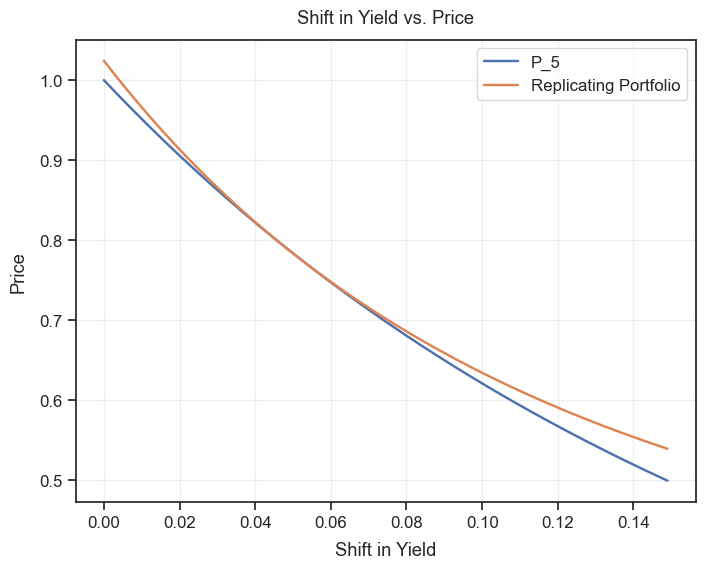

In [566]:
plt.plot(shifts, P_5_change, label = "P_5")
plt.plot(shifts, portfolio_change, label = "Replicating Portfolio")
plt.legend()
plt.xlabel("Shift in Yield")
plt.ylabel("Price")
plt.title("Shift in Yield vs. Price")
plt.show()

In [568]:
## TODO: fix dollar duration of portfolio

P_5_D = np.array([P_5.get_D(shift) for shift in shifts])
portfolio_change_D = np.array([Rep_p.get_D(shift) for shift in shifts])

TypeError: Bond.get_D() takes 1 positional argument but 2 were given

## Observing yield sensitivity

* graph sensitivity like option

## Convexity Hedging

If we want the convexity of our replicating portfolio to match the convexity of $P_5$, we need a third bond in our replicating portfolio.

In [179]:
P_2 = Bond(cs, coupon_rate=0, coupon_period=1, ttm=2, face_value=1)

Now, we can solve for the portfolio value, duration, and convexity. For simplicity, we can take a matrix approach to solving for the portfolio weights:
$$
 \begin{bmatrix}
P_5 \\
D_5P_5 \\
C_5P_5
\end{bmatrix}
=\begin{bmatrix}
P_1 & P_2 & P_{10} \\
D_1P_1 & D_2P_2 & D_{10}P_{10} \\
C_1P_1 & C_2P_2 & C_{10}P_{10} \\
\end{bmatrix} 
\begin{bmatrix}
N^1 \\
N^2 \\
N^{10}
\end{bmatrix} 
$$
$$\downarrow$$
$$
\begin{bmatrix}
N^1 \\
N^2 \\
N^{10}
\end{bmatrix} 
= \begin{bmatrix}
P_1 & P_2 & P_{10} \\
D_1P_1 & D_2P_2 & D_{10}P_{10} \\
C_1P_1 & C_2P_2 & C_{10}P_{10} \\
\end{bmatrix}^{-1}
 \begin{bmatrix}
P_5 \\
D_5P_5 \\
C_5P_5
\end{bmatrix}
$$

In [215]:
A = np.array([[P_1.price, P_2.price, P_10.price],
              [P_1.D * P_1.price, P_2.D * P_2.price, P_10.D * P_10.price],
              [P_1.C * P_1.price, P_2.C * P_2.price, P_10.C * P_10.price],
             ])

a = np.array([[P_5.price],
              [P_5.D * P_5.price],
              [P_5.C * P_5.price]
             ])

In [209]:
A

array([[ 0.95238095,  0.92633677,  0.61391325],
       [ 0.90702948,  1.78313142,  5.8467929 ],
       [ 1.7276752 ,  5.14859891, 61.25211609]])

In [223]:
N = np.linalg.inv(A) @ a

In [225]:
N

array([[-1.3379766 ],
       [ 2.08169876],
       [ 0.21083677]])

In [231]:
N[0][0]

-1.3379766026824762

In [253]:
print(f'Price of P_5: {P_5.price}')
print(f'Duration of P_5: {P_5.D}')
print(f'Convexity of P_5: {P_5.C}')

Price of P_5: 0.7835261664684589
Duration of P_5: 4.761904984292005
Convexity of P_5: 27.21088583632312


In [264]:
# portfolio:
P_P = N[0][0]*P_1.price + N[1][0]*P_2.price + N[2][0]*P_10.price
P_D = N[0][0]*P_1.D*P_1.price + N[1][0]*P_2.D*P_2.price + N[2][0]*P_10.D*P_10.price
P_C = N[0][0]*P_1.C*P_1.price + N[1][0]*P_2.C*P_2.price + N[2][0]*P_10.C*P_10.price

print(f'Price of replicating portfolio: {P_P}')
print(f'Duration of replicating portfolio: {P_D/P_P}')
print(f'Convexity of replicating portfolio: {P_C/P_P}')

Price of replicating portfolio: 0.7835261664684577
Duration of replicating portfolio: 4.761904984292009
Convexity of replicating portfolio: 27.21088583632315


In [288]:
bonds = [P_1, P_2, P_10]

In [290]:
sum([x.price*n[0] for x,n in zip(bonds,N)])

0.7835261664684577

In [278]:
x.rates

array([0.0429    , 0.0406    , 0.03954713, 0.039     , 0.03865454,
       0.0385    , 0.03857798, 0.03884616, 0.03924126, 0.0397    ,
       0.04016837, 0.04062953, 0.04107592, 0.0415    , 0.04189627,
       0.04226755, 0.04261869, 0.04295456, 0.04328004, 0.0436    ])

In [357]:
Rep = Portfolio(bonds, N)

In [359]:
Rep.price

0.7835261664684577

In [361]:
Rep.D

4.761904984292009

In [363]:
Rep.C

27.21088583632316

In [365]:
shifts = np.arange(-0.05, 0.2, 1/1_000)
P_5_change = np.array([P_5.get_price(P_5.rates + shift) for shift in shifts])
portfolio_change = np.array([Rep.get_price(shift) for shift in shifts])

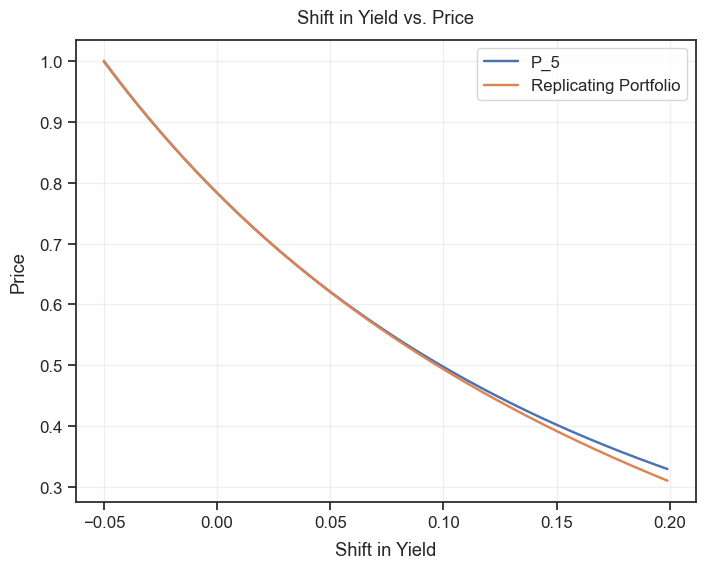

In [367]:
plt.plot(shifts, P_5_change, label = "P_5")
plt.plot(shifts, portfolio_change, label = "Replicating Portfolio")
plt.legend()
plt.xlabel("Shift in Yield")
plt.ylabel("Price")
plt.title("Shift in Yield vs. Price")
plt.show()